# Model tuning

In [39]:
import os
import glob
import numpy as np
import tensorflow as tf

# --- Constants ---
BASE_DIR = "/Users/gracebraz/code/VMontejo/lunar-crater-age-classifier/raw_data/7041842"
CLASS_NAMES = ["ejecta", "oldcrater", "none"]
N_CLASSES = len(CLASS_NAMES)
TARGET_SIZE = (227, 227)
IMAGE_EXT = "*.jpg"

## Image loading and preprocess

In [40]:
# Define the target image size and number of classes based on EDA
def load_and_preprocess_image(file_path, class_label):
    """
    Loads an image from a file path, resizes it, scales pixel values,
    and returns the image tensor and one-hot encoded label.

    Args:
        file_path (tf.Tensor): Tensor containing the image file path (string).
        class_label (tf.Tensor): Tensor containing the integer class label (0, 1, or 2).

    Returns:
        tuple: (preprocessed_image_tensor, one_hot_label_tensor)
    """
    # 1. Load the raw image file as a binary string
    image_raw = tf.io.read_file(file_path)

    # 2. Decode the image
    # The image is decoded as a 3-channel (RGB) tensor of type uint8
    image = tf.image.decode_jpeg(image_raw, channels=3)

    # 3. Resize and convert to float (VGG input requirement)
    image = tf.image.resize(image, TARGET_SIZE)

    # 4. Normalize Pixel Values (0-255 to 0-1)
    image = tf.cast(image, tf.float32) / 255.0

    # 5. One-Hot Encode the Label
    # Converts the integer label (0, 1, or 2) into a vector (e.g., 0 -> [1, 0, 0])
    label = tf.one_hot(class_label, depth=N_CLASSES)

    return image, label

In [41]:
# --- Dataset Creation Function (The Pipeline) ---
def create_dataset(data_set, batch_size=32, cache=False, shuffle=False):
    """
    Creates a high-performance tf.data.Dataset pipeline for a given set.
    """

    # 1. Collect File Paths and Labels
    all_filepaths = []
    all_labels = []

    for label_index, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(BASE_DIR, data_set, class_name)
        filepaths = glob.glob(os.path.join(class_path, IMAGE_EXT))
        all_filepaths.extend(filepaths)
        all_labels.extend([label_index] * len(filepaths))

    # Convert paths and labels to TensorFlow Datasets
    path_dataset = tf.data.Dataset.from_tensor_slices(all_filepaths)
    label_dataset = tf.data.Dataset.from_tensor_slices(all_labels)
    dataset = tf.data.Dataset.zip((path_dataset, label_dataset))

    # 2. Caching (Use if data fits in memory; speeds up repeated epochs)
    if cache:
        # Caching the data *after* the heavy loading/preprocessing step.
        dataset = dataset.cache()

    # 3. Shuffling (Only for the training set)
    if shuffle:
        # Buffer size should be large, e.g., the size of the training set or more
        dataset = dataset.shuffle(buffer_size=len(all_filepaths) * 2)

    # 4. Mapping (The core image loading, with parallelization)
    # tf.data.AUTOTUNE allows TensorFlow to select optimal thread count dynamically
    dataset = dataset.map(load_and_preprocess_image,
                          num_parallel_calls=tf.data.AUTOTUNE)

    # 5. Batching and prefetching (Performance optimization)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, len(all_filepaths)

In [49]:
# --- Execution ---
# Generate the datasets for use in model.fit()
BATCH_SIZE = 64
# Cache is recommended for the training set if your computer has sufficient RAM
train_set, train_count = create_dataset("train", batch_size=BATCH_SIZE, shuffle=True, cache=True)
val_set, val_count = create_dataset("val", batch_size=BATCH_SIZE)
test_set, test_count = create_dataset("test", batch_size=BATCH_SIZE)

print(f"\nTraining Dataset (Cached, Shuffled): {train_count} files")
print(f"Validation Dataset: {val_count} files")
print(f"Test Dataset: {test_count} files")

# --- Verification of Batch Shapes ---

# Use .take(1) to get the first batch, and iter() to convert it to a Python iterable
# Note: TensorFlow's API for getting shapes from a batched dataset often requires iterating once.
first_train_batch = next(iter(train_set.take(1)))
train_image_batch, train_label_batch = first_train_batch

print("\n--- First Batch Shape Verification ---")
print(f"Training Batch Size (Max): {train_image_batch.shape[0]}")
print(f"Image Batch Shape: {train_image_batch.shape}")
print(f"Label Batch Shape: {train_label_batch.shape}")
print(f"Image Dtype: {train_image_batch.dtype}")
print(f"Label Dtype: {train_label_batch.dtype}")


Training Dataset (Cached, Shuffled): 3608 files
Validation Dataset: 613 files
Test Dataset: 779 files

--- First Batch Shape Verification ---
Training Batch Size (Max): 64
Image Batch Shape: (64, 227, 227, 3)
Label Batch Shape: (64, 3)
Image Dtype: <dtype: 'float32'>
Label Dtype: <dtype: 'float32'>


## Define and freeze base model

In [50]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam

# --- Constants from EDA ---
TARGET_INPUT_SHAPE = (227, 227, 3) # (Height, Width, Channels)
N_CLASSES = 3

# 1. Load the pre-trained VGG16 base model
# weights='imagenet' loads the pre-trained weights
# include_top=False discards the original classification layer
vgg16_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=TARGET_INPUT_SHAPE
)

# 2. Freeze the base layers (Transfer Learning Core Principle)
# We prevent the ImageNet-learned feature detectors from being damaged
# by large gradients during the initial, random-headed training phase.
for layer in vgg16_base.layers:
    layer.trainable = False

## Build the New Classification Head

In [51]:
# Create the new classification head (Top of the network)
x = vgg16_base.output

# Global Average Pooling: Efficiently reduces the output of the convolutional
# layers to a flat vector, ready for the Dense layers.
x = GlobalAveragePooling2D(name='global_avg_pool')(x)

# Dense layer for feature refinement, using regularization
x = Dense(128, activation='relu', name='fc_head_1')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout_1')(x)

# Final output layer: 3 units for the 3 classes, using Softmax for probabilities
predictions = Dense(N_CLASSES, activation='softmax', name='predictions')(x)

# --- 3. Create the Final Model ---
model = Model(inputs=vgg16_base.input, outputs=predictions)

# 4. Compile the Model
model.compile(
    optimizer=Nadam(learning_rate=3e-3),
    loss='categorical_crossentropy', # Used with one-hot encoded labels
    metrics=['accuracy']
)

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 227, 227, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 227, 227, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 113, 113, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 113, 113, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_head_1 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Required before training

VGG16 specific preprocessing layer into our model. The cleanest way is to add it as the first step of our final model

In [52]:
# VGG16 has a specific preprocessing function that needs 0-255 scaled input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input

# Apply this to the batched data. Since our `train_set`currently outputs 0-1, we need to rescale back to 0-255 first.

# The new input data should be:
# `vgg_preprocess(train_image_batch * 255.0)`

## 🧠 Model Prototyping: VGG16 Transfer Learning Shell

### 1. The VGG16 Transfer Learning Model Definition
The model is defined exactly as in the previous step, including loading the base, freezing it, and attaching your custom 3-class classification head.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# --- Constants ---
TARGET_INPUT_SHAPE = (227, 227, 3)
N_CLASSES = 3

def build_vgg16_transfer_model():
    # 1. Load the pre-trained VGG16 base model
    vgg16_base = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=TARGET_INPUT_SHAPE
    )

    # 2. Freeze the base layers (Transfer Learning Core Principle)
    for layer in vgg16_base.layers:
        layer.trainable = False

    # 3. Build the New Classification Head
    x = vgg16_base.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dense(128, activation='relu', name='fc_head_1')(x)
    x = Dropout(0.5, name='dropout_1')(x) # Regularization
    predictions = Dense(N_CLASSES, activation='softmax', name='predictions')(x)

    # 4. Create and Compile the Final Model
    model = Model(inputs=vgg16_base.input, outputs=predictions)

    # Use Nadam with an initial low learning rate (Transfer Learning Best Practice)
    model.compile(
        optimizer=Nadam(learning_rate=3e-3),
        loss='categorical_crossentropy', # For one-hot encoded labels
        metrics=['accuracy']
    )

    return model

### 2. Execution with Data Pipeline Integration
Now, we need to integrate the create_dataset output (which is scaled $0-1$) and the class weights into the training call.Since VGG16 expects inputs scaled $0-255$ with specific centering, we'll use a wrapper function in the dataset map to perform the full ImageNet preprocessing, ensuring optimal transfer learning performance.

In [54]:
# Hardcoded Class Weights from Imbalance Analysis
CLASS_WEIGHTS = {
    0: 3.359,  # New Crater (ejecta)
    1: 2.025,  # Old Crater
    2: 0.453   # No Crater (none)
}

In [55]:
import tensorflow.keras.applications.vgg16
from tensorflow.keras import callbacks

# --- Data Transformation Helper ---
# VGG16 requires a specific preprocessing step (ImageNet mean subtraction).
# The current pipeline outputs 0-1 scaled images. We must rescale back to 0-255
# before applying VGG's complex preprocessing.
def vgg16_preprocessing_wrapper(image, label):
    # Rescale from 0-1 back to 0-255 (which VGG preprocess_input expects)
    image_255 = image * 255.0

    # Apply VGG's specific mean subtraction and scaling
    preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image_255)

    return preprocessed_image, label


# --- Prepare Datasets for VGG16 ---

# Apply the VGG16-specific preprocessing to the *training set*
train_set_vgg = train_set.map(vgg16_preprocessing_wrapper,
                              num_parallel_calls=tf.data.AUTOTUNE)

# Apply the VGG16-specific preprocessing to the *validation set*
val_set_vgg = val_set.map(vgg16_preprocessing_wrapper,
                          num_parallel_calls=tf.data.AUTOTUNE)

# Apply the VGG16-specific preprocessing to the *test set*
test_set_vgg = test_set.map(vgg16_preprocessing_wrapper,
                            num_parallel_calls=tf.data.AUTOTUNE)


# --- Training Execution ---

# 1. Calculate Class Weights (Run this using the code from the previous coaching step!)
# class_weights = {0: 3.370, 1: 2.029, 2: 0.453} # Placeholder weights for visualization

# 2. Build the model
model = build_vgg16_transfer_model()

# 3. Fit the model using the optimized datasets and class weights
history = model.fit(
    train_set_vgg,
    epochs=10, # Start with a few epochs to train the new head only
    steps_per_epoch=train_count // BATCH_SIZE,
    validation_data=val_set_vgg,
    validation_steps=val_count // BATCH_SIZE,
    class_weight=CLASS_WEIGHTS # Use the weights calculated earlier!
)

print("\n--- Initial Training Complete (Head Only) ---")

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 581s 10s/step - accuracy: 0.5826 - loss: 1.0363 - val_accuracy: 0.6042 - val_loss: 0.8758
Epoch 2/10
 1/56 ━━━━━━━━━━━━━━━━━━━━ 2:59 3s/step - accuracy: 0.6667 - loss: 0.5571

/Users/gracebraz/.pyenv/versions/3.10.6/envs/lunar-crater-age-classifier/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6667 - loss: 0.5571 - val_accuracy: 0.6094 - val_loss: 0.8681
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 650s 12s/step - accuracy: 0.6599 - loss: 0.7143 - val_accuracy: 0.6319 - val_loss: 0.7897
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8333 - loss: 0.3549 - val_accuracy: 0.6389 - val_loss: 0.7822
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 665s 12s/step - accuracy: 0.6867 - loss: 0.6627 - val_accuracy: 0.6528 - val_loss: 0.7972
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.5417 - loss: 0.7437 - val_accuracy: 0.6684 - val_loss: 0.7611
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 645s 12s/step - accuracy: 0.6897 - loss: 0.6465 - val_accuracy: 0.6493 - val_loss: 0.7707
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7500 - loss: 0.5506 - val_accuracy: 0.6493 - val_loss: 0.7840
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 696s 12s/step - accuracy: 0.6959 - loss: 0.6177 - val_accuracy: 0.6406 - val_loss: 0.

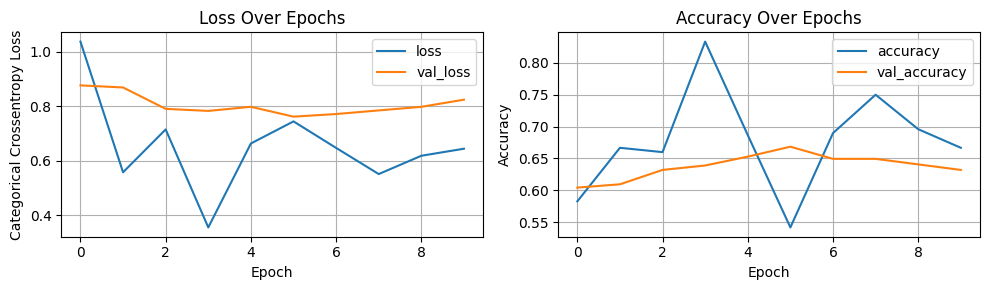

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# The 'history' object contains the training metrics for each epoch
history_df = pd.DataFrame(history.history)

# Plotting Loss and Accuracy over epochs
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# --- Plot 1: Loss Curves ---
history_df[['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_title('Loss Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Categorical Crossentropy Loss')
axes[0].grid(True)

# --- Plot 2: Accuracy Curves ---
history_df[['accuracy', 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title('Accuracy Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

plt.tight_layout()
plt.show();

## Metrics
Since we have already trained the model (model) and have the final test_set ready, we can check some metrics.

In [57]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# --- Constants (Needed to map labels) ---
CLASS_NAMES = ["New Crater (0)", "Old Crater (1)", "No Crater (2)"]

# 1. Generate Predictions on the Test Set
print("Generating predictions on the test set...")
# Note: Use the test_set_vgg which has the correct VGG preprocessing applied
# test_set_vgg and test_count must be available from the previous steps.

# Create an iterable for the test set
test_data_iterable = test_set_vgg.unbatch().as_numpy_iterator()

# Extract images and true labels
y_true_list = []
x_test_list = []

for image, label in test_data_iterable:
    x_test_list.append(image)
    y_true_list.append(np.argmax(label)) # Convert one-hot to integer label

X_test_all = np.array(x_test_list)
y_true = np.array(y_true_list)

# Get predicted probabilities (softmax output)
y_proba = model.predict(test_set_vgg)

# Convert probabilities to hard integer predictions (class index with max proba)
y_pred = np.argmax(y_proba, axis=1)

# 2. Print Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# 3. Print Classification Report (Precision, Recall, F1-score)
print("\n--- Classification Report (Per-Class Metrics) ---")
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=3)
print(report)

Generating predictions on the test set...


2025-12-09 10:08:01.014755: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


13/13 ━━━━━━━━━━━━━━━━━━━━ 117s 9s/step

--- Confusion Matrix ---
[[ 67   6  16]
 [ 10 119  28]
 [ 71  92 370]]

--- Classification Report (Per-Class Metrics) ---
                precision    recall  f1-score   support

New Crater (0)      0.453     0.753     0.565        89
Old Crater (1)      0.548     0.758     0.636       157
 No Crater (2)      0.894     0.694     0.781       533

      accuracy                          0.714       779
     macro avg      0.632     0.735     0.661       779
  weighted avg      0.774     0.714     0.728       779

